**Imports**

In [364]:
# ---------------------------------------------- Imports ----------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

**Constantes**

In [365]:
L = 0.230
R = 0.035
ROBOT = "kobuki"
LASER = "fastHokuyo"

robot_path = []
obstacle_points = []

# fig = plt.figure(figsize=(8,8), dpi=100)
# ax = fig.add_subplot(111, aspect='equal')

map_size = np.array([10,10])
cell_size = 0.1
rows, cols = (map_size/cell_size).astype(int)
print(rows, cols)
occ_grid = np.full((rows, cols), 0.5)
# grid = np.full((rows, cols), 0.5)
# CELL_SIZE = 0.1
print(occ_grid)
print(len(occ_grid))


# m = np.random.uniform(low=0.0, high=1.0, size=(rows, cols))

# m[0,0] = 1 
# plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))

# ax.set_xticks(np.arange(0, cols, 1))
# ax.set_yticks(np.arange(0, rows, 1))

# plt.colorbar()
# print(occ_grid)

100 100
[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
100


Log odds

In [366]:
#odds
def prob_to_log_odds(prob):
    odds = prob/(1 - prob)
    return np.log(odds)

def log_odds_to_prob(log_odds):
    return (1 - (1 / (1 + np.exp(log_odds))))

Algoritmo de Bresenham

In [367]:
def bresenham(x0, y0, x1, y1):
    """Algoritmo de Bresenham para gerar pontos entre (x0, y0) e (x1, y1)."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

Inverse Sensor Model

In [368]:
# 3 possibilidade:
# tem uma grande chance das celulas estarem livre entre o sensor e a posição que fiz a leitura estar livre, pq se nao eu nao iria conseguir fazer a leitura
# as posições um pouco antes e um pouco depois tem uma chance de estarem ocupadas porque é onde eu fiz a leitura
# e o que ta depois do sensor eu nao sei o que tem la, entao como eu nao sei eu considero a probabilidade anterior que tava naquela celula

#Essa função vai avaliar uma celula por vez aqui.
#m_i vai ser a celula que eu to avaliando no momento
#x_t sao as coordenadas do robo
#z_t pode ser uma leitura de um sensor LIDAR, sonar, ou qualquer outro sensor de distância, que mede a distância até o obstáculo mais próximo a partir da posição atual do robô.
#é a probabilidade inicial ou a priori de ocupação da célula.

# def inverse_range_sensor_model(m_i, x_t, z_t, prob):
#     x_i, y_i = m_i  # Centro de massa da célula m_i
#     x, y = x_t  # Posição do robô
#     z_max = 5 / cell_size  # Distância máxima
#     alpha = 0.2 / cell_size
    
#     # Cálculo explícito da distância r, que representa a distancia entre o robo e o centro da celula mi
#     r = np.sqrt((x_i - x)**2 + (y_i - y)**2)
    
#     l_occ = log_odds_to_prob(0.85)
#     l_free = log_odds_to_prob(0.1)
#     l_0 = log_odds_to_prob(prob)
#     # print("logs: ", l_occ, l_free, l_0)
#     # Correspondência para z_t (distancemax) no algoritmo original
#     z_k_t = z_t
#     #Se for maior, retorna l_0, indicando que a célula está na área desconhecida.
#     if r > min(z_max, z_k_t + alpha / 2):
#         return l_0
#     #Se ambas as condições forem verdadeiras, retorna l_occ, indicando que a célula provavelmente está ocupada.
#     if z_k_t < z_max and abs(r - z_k_t) < alpha / 2:
#         return l_occ
#     #Se for verdadeira, retorna l_free, indicando que a célula está livre.
#     if r <= z_k_t:
#         return l_free     
    
def inverse_range_sensor_model(m_i, x_t, z_t, prob):
    # x_i, y_i = m_i  # Centro de massa da célula m_i
    # x, y = x_t  # Posição do robô
    z_max = 5 / cell_size  # Distância máxima
    alpha = 0.2 / cell_size
    
    # Cálculo explícito da distância r, que representa a distancia entre o robo e o centro da celula mi
    r = np.linalg.norm(m_i - x_t[:2])
    
    l_occ = log_odds_to_prob(0.85)
    l_free = log_odds_to_prob(0.1)
    l_0 = log_odds_to_prob(prob)
    # print("logs: ", l_occ, l_free, l_0)
    # Correspondência para z_t (distancemax) no algoritmo original
    # z_k_t = z_t
    #Se for maior, retorna l_0, indicando que a célula está na área desconhecida.
    if r > min(z_max, z_t + alpha / 2):
        return l_0
    #Se ambas as condições forem verdadeiras, retorna l_occ, indicando que a célula provavelmente está ocupada.
    if z_t < z_max and abs(r - z_t) < alpha / 2:
        return l_occ
    #Se for verdadeira, retorna l_free, indicando que a célula está livre.
    if r <= z_t:
        return l_free     

Algoritmo Occupancy Grid

In [369]:
from skimage.draw import line

# Função principal de mapeamento com navegação
# def occupancy_grid_mapping(cel_robo, cel_final, occ_grid, sensor_reading, initial_prob=0.5):
#     # distancemax = np.linalg.norm(cel_robo - cel_final)
#     path = bresenham(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
#     l_0 = log_odds_to_prob(initial_prob)
    
#     for (x, y) in path:
#         celula_prob = occ_grid[x, y]
#         l_ant = log_odds_to_prob(celula_prob)
#         celula = [x, y]
#         r = np.sqrt((celula[0] - cel_robo[0])**2 + (celula[1] - cel_robo[1])**2)
        
#         if r <= sensor_reading + 5:
#             l_cell = l_ant + inverse_range_sensor_model(celula, cel_robo, sensor_reading, celula_prob) - l_0
#         else:
#             l_cell = l_ant
        
#         occ_grid[x, y] = prob_to_log_odds(l_cell)

#celular final é quando detectou um obstaculo
def occupancy_grid_mapping(cel_robo, cel_final):
    distancemax = np.linalg.norm(cel_robo - cel_final)
    #FORMA UMA LINHA RETA ENTRE O ROBO E A CELULA FINAL
    rr, cc = line(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
    
    #PERCORRO POR TODA A LINHA QUE ESTÁ ENTRE O ROBO E A CELULA FINAL
    for i in range(len(rr)):
        celula_prob = occ_grid[rr[i], cc[i]] #PEGO A PROBABILIDADE NA CELULA QUE EU ESTOU
        l_ant = log_odds_to_prob(celula_prob) #PASSO PARA LOG
        celula = [rr[i], cc[i]]
        # r = np.sqrt((celula[0] - cel_robo[0])**2 + (celula[1] - cel_robo[1])**2)
        
        l_cell = l_ant + inverse_range_sensor_model(celula, cel_robo, distancemax, celula_prob)
        
        occ_grid[rr[i], cc[i]] = prob_to_log_odds(l_cell) #armazena a nova probabilidade no grid de ocupação

In [370]:
def convert_laser_reading_to_cell_values(xo,yo):
    max_cel = len(occ_grid) - 1

    i = np.floor(xo / cell_size).astype(int)
    j = np.floor(yo / cell_size).astype(int)
    
    i = min(max_cel, i)
    j = min(max_cel, j)
    
    return i, j

**Init**

In [371]:
# ---------------------------------------------- Init ----------------------------------------
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

**Leitura do Sensor**

In [372]:
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    signalName = sim.waitForSignal(range_data_signal_id)
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # retornar nenhum caso nada tenha sido obtido do simulador
    return None

**Cálculo Matriz de Rotação**

In [373]:
def get_rotation_matrix(thetaZ):
    return np.array([[  np.cos(thetaZ), -np.sin(thetaZ), 0 ],
                      [ np.sin(thetaZ),  np.cos(thetaZ), 0 ],
                      [ 0            ,  0            , 1 ]])

def get_rotation_matrix_laser_world():
    objectHandle_RP = sim.getObject("/" + ROBOT)
    origin_RP = np.array(sim.getObjectPosition(objectHandle_RP, 
                                        sim.handle_world))

    objectHandle_Laser = sim.getObject("/" + LASER)
    origin_Laser = np.array(sim.getObjectPosition(objectHandle_Laser, 
                                        sim.handle_world))
    p_Laserorg = origin_Laser - origin_RP
    eulerAngles_Laser = sim.getObjectOrientation(objectHandle_Laser, 
                                                objectHandle_RP)

    aux = np.array([0, 0, 0, 1])
    rotationMatrix_Laser = get_rotation_matrix(eulerAngles_Laser[2])
    transformationMatrix_Laser = np.column_stack((rotationMatrix_Laser, p_Laserorg))
    transformationMatrix_Laser = np.row_stack((transformationMatrix_Laser, aux))

    #Matriz de Transformação Robô -> mundo
    origin_World = np.array([0,0,0])
    p_RPorg = origin_RP - origin_World
    eulerAngles_RP = sim.getObjectOrientation(objectHandle_RP, 
                                                sim.handle_world)
    rotationMatrix_RP = get_rotation_matrix(eulerAngles_RP[2])
    transformationMatrix_World = np.column_stack((rotationMatrix_RP, p_RPorg))
    transformationMatrix_World = np.row_stack((transformationMatrix_World, aux))
    
    #Matriz de Transformação Laser -> Mundo
    return transformationMatrix_Laser @ transformationMatrix_World

**Campos Potenciais**

In [374]:
#Calcula a força de atração 
def att_force(q, goal, k=5):
    f = k*(goal - q)
    return f

#Calcula a força de repulsão
def rep_force(q, obs, R=1.5, krep=.005):
    Frep_total = np.array([0.0, 0.0])
    for obstacle in obs:
        v = q[0:2] - obstacle
        d = np.linalg.norm(v) # Calcula a distância entre o robô e o obstáculo

        # Calcula a força de repulsão apenas se a distância for menor que R
        if (d < R):  
            rep = (1/d**2)*((1/d)-(1/R))*(v/d) 
            Frep_total += rep

    return krep*Frep_total

**Occupancy Grid**

In [375]:
# #Leitura -> Célula
# def convert_robot_read_to_laser(pos_robot):
#     matrix = np.array([])

# def convert_laser_to_cell():
#     return laser_position/cell_size

In [376]:
def Rz(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

**Navegação**

In [377]:
import time
def navigation(qgoal):
    robotHandle = sim.getObject("/" + ROBOT)  
    robotLeftMotorHandle = sim.getObject("/" +'kobuki_leftMotor')
    robotRightMotorHandle = sim.getObject("/" +'kobuki_rightMotor')

    maxv = 0.2 #LIMITADORES DA VELOCIDADE LINEAR
    maxw = np.deg2rad(45) #LIMITADORES DA VELOCIDADE ANGULAR

    rho = np.inf
    random_force = 0.1
    max_sensor_range = 5
    start_time = time.time()
    while rho > .05:
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time >= 5:
            break
        obstacle = []

        #Configuração do robo
        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
        robotPos = robotPos[0:2]
        robot_path.append(robotPos)
        robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

        raw_range_data, raw_angle_data = readSensorData()
        laser_data = np.array([raw_angle_data, raw_range_data]).T

        #Transformação dos dados do meu laser para o mundo
        transformationMatrix_LaserWorld = get_rotation_matrix_laser_world()

        for i in range(len(laser_data)):
            ang, dist = laser_data[i] #pega os valores de angulo e distância

            if (max_sensor_range - dist) > 0.1:
                x = dist * np.cos(ang) #meu x
                y = dist * np.sin(ang) #meu y
                point = np.array([x,y,0,1])

                if len(transformationMatrix_LaserWorld) != 0:
                    point = transformationMatrix_LaserWorld @ point
                    obstacle.append(point[0:2])
                    obstacle_points.append(point)

                    # sensor_reading = np.linalg.norm(robotPos - point[0:2])
                    
                    # print("sensor_reading", sensor_reading)
                    # print("robotPos, point[0:2]: ", robotPos, point[0:2])
                    # print("occ_grid", occ_grid)
                    # print("teste", point[0:2])
                    # max_cel = len(occ_grid) - 1

                    # robotPos_x, robotPos_y = robotPos
                    # obstacle_x, obstacle_y = point[0:2]
                    # robotPos = np.floor((1/1)*np.array([robotPos_x, robotPos_y])).astype(int)
                    # obstaclePos = np.floor((1/1)*np.array([obstacle_x, obstacle_y])).astype(int)
                    obstaclePos = point[0:2]
                    # print("CARALHO", obstaclePos[0])
                    # fim_laser = Rz(np.pi / 2) @ [(obstaclePos[0] + map_size[0] / 2), (obstaclePos[1] + map_size[1] / 2), 0]
                    # robo_mapa = Rz(np.pi / 2) @ [(robotPos[0] + map_size[0] / 2), (robotPos[1] + map_size[1] / 2), 0]
                    
                    # robotPos_ = (robotPos / 0.1).astype(int)
                    # obstaclePos_ = (obstaclePos / 0.1).astype(int)

                    robotPos_x, robotPos_y = convert_laser_reading_to_cell_values(robotPos[0],robotPos[1])
                    obstaclePos_x, obstaclePos_y = convert_laser_reading_to_cell_values(obstaclePos[0],obstaclePos[1])
                    robotPos_ = np.array([robotPos_x, robotPos_y])
                    # print("aqui", robotPos_)
                    obstaclePos_ = np.array([obstaclePos_x, obstaclePos_y])
                    # robox = min(max_cel, int(robo_mapa[0]/0.1))  # posição x do robo na célula do mapa occ grid
                    # roboy = min(max_cel, int(robo_mapa[1]/0.1))  # posição y do robo na célula do mapa occ grid
                    # celulax = min(max_cel, int(fim_laser[0]/0.1))  # posição x de onde o laser bateu na célula do mapa occ grid
                    # celulay = min(max_cel, int(fim_laser[1]/0.1)
                    # robotPos_ = np.array([robox,roboy])
                    # obstaclePos_ = np.array([celulax,celulay])
                    # print("aqui", robotPos_, obstaclePos_)
                    
                    occupancy_grid_mapping(robotPos_, obstaclePos_)   
        
        Fatt = att_force(robotPos, qgoal)
        Frep = rep_force(robotPos, obstacle)

        random_force_vector = random_force * np.random.rand(2)
        Ft = Fatt + Frep + random_force_vector
        Ft_x = Ft[0]
        Ft_y = Ft[1]

        # Apenas para interromper o loop
        rho = np.sqrt(Ft_x**2 + Ft_y**2)
        
        # Formula De Luca e Oriolo para calcular a velocidade linear e angular.
        kr = 0.05
        kt = 0.1
        v = kr*(Ft_x*np.cos(robotConfig[2]) + Ft_y*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(Ft_y,Ft_x) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((1.0*v) + (w*L))/(2.0*R)
        vl = ((1.0*v) - (w*L))/(2.0*R)
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)

    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)



**MAIN**

In [378]:
# TESTE 1
qgoals = []
qgoals.append([1.5, 3])
qgoals.append([3.4, 4])
qgoals.append([0.4, 4])
qgoals.append([1.0, 0])
qgoals.append([0.5, -4.5])

C:\Users\eduar\AppData\Local\Temp/ipykernel_14404/2054203346.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(odds)


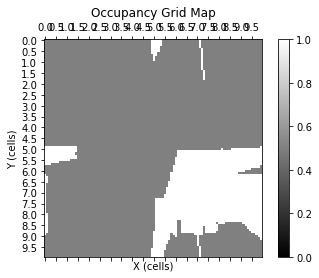

In [379]:
sim.startSimulation()

reference_frame_handle = sim.getObject("/" + "ReferenceFrame")

for qgoal in qgoals:
        reference_frame_position = qgoal.copy()
        reference_frame_position.append(0)
        sim.setObjectPosition(reference_frame_handle, reference_frame_position)
        navigation(np.array(qgoal))

sim.stopSimulation()
# Após o término da simulação
# Plotando o caminho do robô

fig, ax = plt.subplots()

# Exibir a matriz do Occupancy Grid com uma escala de cores ajustada
cax = ax.matshow(occ_grid, cmap='gray', vmin=0, vmax=1)

# Adicionar uma barra de cores para referência
fig.colorbar(cax)

# Definir título e rótulos dos eixos
ax.set_title('Occupancy Grid Map')
ax.set_xlabel('X (cells)')
ax.set_ylabel('Y (cells)')

# Ajustar rótulos dos eixos para refletir o tamanho da célula
ticks = np.arange(0, occ_grid.shape[0], step=5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels((ticks * 0.1).astype(float))
ax.set_yticklabels((ticks * 0.1).astype(float))

# Salvar a figura como uma imagem
plt.savefig("occupancy_grid_map.png")
plt.show()
# print("occ_grid", occ_grid)

# robot_path = np.array(robot_path)
# plt.plot(robot_path[:, 0], robot_path[:, 1], '-r', label='Caminho do Robô')

# # Plotando os obstáculos
# # for point in obstacle_points:
# #         plt.plot(point[0], point[1], 'o', color='b')
# obstacle_points = np.array(obstacle_points)
# plt.plot(obstacle_points[:, 0], obstacle_points[:, 1], 'o', color='b', label='Obstáculos')

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Caminho do Robô e Obstáculos')
# plt.legend()
# plt.grid(True)
# plt.axis('equal')